In [1]:
import glob
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import math

from unet import UNetModel
from utils import *
from diffusion import GaussianDiffusion

import tqdm
import matplotlib.pyplot as plt

## Load Data

In [2]:
import rasterio
from torch.utils.data.dataset import Dataset

class PatchDataset(Dataset):
    def __init__(self, naip_paths_list, label_paths_list, clustering_paths_list, prior_paths_list,
                 patch_size, mapping=None, transforms=None):
        self.naip_paths_list = naip_paths_list
        self.label_paths_list = label_paths_list
        self.clustering_paths_list = clustering_paths_list
        self.prior_paths_list = prior_paths_list
        
        self.patch_size = patch_size
        self.mapping = mapping
        if transforms is None:
            self.transforms = lambda x: x
        else:
            self.transforms = transforms

        # Load tiles
        self.naip = []
        for path in self.naip_paths_list:
            with rasterio.open(path) as f:
                self.naip.append(f.read())
        print('Loaded', len(self.naip), 'NAIP tiles')

        self.labels = []
        for path in self.label_paths_list:
            with rasterio.open(path) as f:
                # Apply label mapping
                label_raster = f.read()
                label_raster = self.mapping[label_raster.astype(np.uint8)]
                self.labels.append(label_raster)
        print('Loaded', len(self.labels), 'label tiles')
        
        self.clusters = []
        for path in self.clustering_paths_list:
            with rasterio.open(path) as f:
                self.clusters.append(f.read())
        print('Loaded', len(self.clusters), 'clustering tiles')
                
        self.priors = []
        for path in self.prior_paths_list:
            with rasterio.open(path) as f:
                # Apply label mapping
                prior_raster = f.read()
                prior_raster = np.concatenate((np.zeros((1,prior_raster.shape[1],prior_raster.shape[2])), prior_raster), axis=0).astype(float)
                prior_raster = prior_raster / (np.sum(prior_raster, axis=0, keepdims=True) + 1e-4)
                self.priors.append(prior_raster)
        print('Loaded', len(self.priors), 'prior tiles')
  
        
    def __len__(self):
        assert len(self.naip_paths_list) == len(self.label_paths_list), 'NAIP/Labels tiles mismatch'
        return len(self.naip_paths_list)

    def __getitem__(self, idx):
        '''
        Args:
            idx (int): Index of tile to sample from
        '''
        # Select the tile to get a random patch from
        naip = self.naip[idx]
        labels = self.labels[idx]
        clusters = self.clusters[idx]
        prior = self.priors[idx]
        
        # Randomly select patch in tile
        height, width = naip.shape[1], naip.shape[2]
        row = torch.randint(0, height - self.patch_size[0], size=(1,)).item()
        col = torch.randint(0, width - self.patch_size[1], size=(1,)).item()

        # Use copy to not modify the original labels
        naip_patch = naip[:, row:row+self.patch_size[0], col:col+self.patch_size[1]].copy()
        labels_patch = labels[:, row:row+self.patch_size[0], col:col+self.patch_size[1]].copy()
        clusters_patch = clusters[:, row:row+self.patch_size[0], col:col+self.patch_size[1]].copy()
        prior_patch = prior[:, row:row+self.patch_size[0], col:col+self.patch_size[1]].copy()

        # Apply transforms
        naip_patch = torch.from_numpy(naip_patch)
        labels_patch = torch.from_numpy(labels_patch)
        clusters_patch = torch.from_numpy(clusters_patch)
        prior_patch = torch.from_numpy(prior_patch)
        
        naip_patch, labels_patch, clusters_patch, prior_patch = self.transforms(naip_patch, labels_patch, clusters_patch, prior_patch)
        
        return {'naip': naip_patch, 'labels': labels_patch, 'clusters': clusters_patch, 'prior': prior_patch}
    

In [144]:
# Specify tiles
naip_paths = glob.glob('data/enviroatlas_lotp/austin_tx-2012_1m-test_tiles-debuffered/*naip.tif')
naip_paths.sort()
label_paths = glob.glob('data/enviroatlas_lotp/austin_tx-2012_1m-test_tiles-debuffered/*highres_labels.tif')
label_paths.sort()
cluster_paths = glob.glob('data/enviroatlas_lotp/austin_tx-2012_1m-test_tiles-debuffered/*naip_oc.tif')
cluster_paths.sort()
prior_paths = glob.glob('data/enviroatlas_lotp/austin_tx-2012_1m-test_tiles-debuffered/*prior_from_cooccurrences_101_31.tif')
prior_paths.sort()

# Transforms to apply
def transforms(img, labels, clusters, prior):
    # Resizing
    img = F.interpolate(img.unsqueeze(0).float(), scale_factor=1, mode='nearest').squeeze(0) / 255.
    labels = F.interpolate(labels.unsqueeze(0).float(), scale_factor=1/4, mode='nearest').squeeze(0)
    clusters = F.interpolate(clusters.unsqueeze(0).float(), scale_factor=1/4, mode='nearest').squeeze(0)
    prior = F.interpolate(prior.unsqueeze(0).float(), scale_factor=1/4, mode='nearest').squeeze(0)

    return img, labels, clusters, prior
    
# Create data set
device = torch.device('cuda:0')
patch_size = (256,256)
n_labels = len(enviroatlas_simplified_labels)
n_clusters = 5
dataset = PatchDataset(naip_paths, label_paths, cluster_paths, prior_paths,
                       patch_size=patch_size, 
                       mapping=enviroatlas_simplified_label_mapping_array,
                       transforms=transforms)

# Create random patch-sampling dataloader
batch_size = 32
sampler = torch.utils.data.RandomSampler(dataset, replacement=True, num_samples=batch_size)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, num_workers=0, sampler=sampler)
print('Created dataset')

Loaded 10 NAIP tiles
Loaded 10 label tiles
Loaded 10 clustering tiles
Loaded 10 prior tiles
Created dataset


In [145]:
# Create random patch-sampling dataloader
batch_size = 1
sampler = torch.utils.data.RandomSampler(dataset, replacement=True, num_samples=batch_size)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, num_workers=0, sampler=sampler)
print('Created dataset')

Created dataset


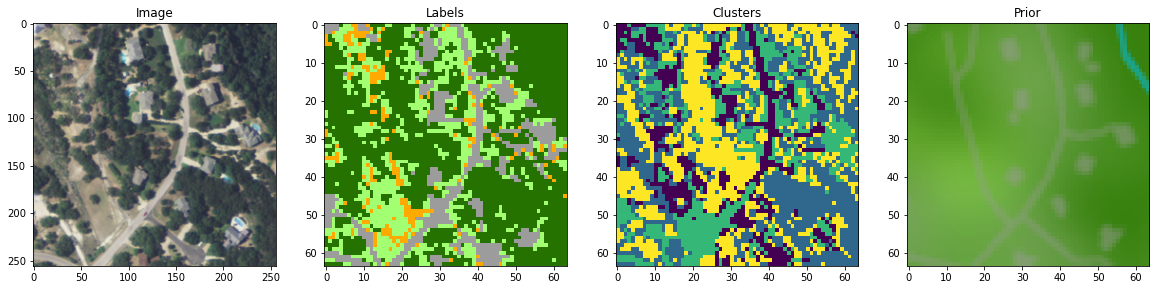

In [146]:
# Sample random batch
for batch in dataloader:
    naip = batch['naip']
    labels = batch['labels']
    clusters = batch['clusters']
    prior = batch['prior']
    
    labels_one_hot = F.one_hot(labels.long(), n_labels).transpose(-1,1).squeeze(-1).float()
    clusters_one_hot = F.one_hot(clusters.long(), n_clusters).transpose(-1,1).squeeze(-1).float()
    break
    
# Visualize
fig, ax = plt.subplots(1, 4, figsize=(20, 5))
ax[0].imshow(naip[0].numpy().transpose([1,2,0])[:,:,:3])
ax[0].set_title('Image')
ax[1].imshow(labels[0,0,:,:], cmap=enviroatlas_simplified_cmap, vmin=0, vmax=n_labels-1, interpolation='none')
ax[1].set_title('Labels')
ax[2].imshow(clusters[0].numpy().transpose([1,2,0])[:,:,:3])
ax[2].set_title('Clusters')
ax[3].imshow(labels_to_color(prior[0].cpu().numpy(), False, enviroatlas_simplified_labels, enviroatlas_simplified_label_colors))
ax[3].set_title('Prior')
plt.show()

## Load Model

In [6]:
diffusion_net = UNetModel(image_size=64, in_channels=n_labels, out_channels=n_labels, 
                          model_channels=128, num_res_blocks=2, channel_mult=(1,2,3,4),
                          attention_resolutions=[16,8], num_heads=4).to(device)

diffusion_net.train()
diffusion_net.load_state_dict(torch.load('models/unet_100000.pth'))

<All keys matched successfully>

In [31]:
diffusion = GaussianDiffusion(T=1000, schedule='linear')

x = torch.randn((32,n_labels,64,64)).float().to(device)

with torch.no_grad():
    diffusion_net.eval()
    sample = diffusion.inverse(diffusion_net, shape=(n_labels,64,64), device=device, x=x)
    diffusion_net.train()

fig, ax = plt.subplots(1, 1, figsize=(5,5))
ax.imshow(labels_to_color(sample[0].cpu().numpy(), False, enviroatlas_simplified_labels, enviroatlas_simplified_label_colors))
ax.set_title('Sample')
plt.show()

KeyboardInterrupt: 

## Run Inference

In [7]:
class MILoss(nn.Module):
    def __init__(self, win_size=15):
        super(MILoss, self).__init__()
        
        self.pooling = nn.Sequential(
            nn.AvgPool2d(win_size, 1, (win_size-1)//2, count_include_pad=False),
            #nn.AvgPool2d(win_size, 1),
        )
    
    def forward(self, labels, clusters, n_clusters):
        labels = F.normalize(labels + 1e-9, p=1, dim=1)
        clusters = F.normalize(clusters + 1e-9, p=1, dim=1)
        
        plc = []
        for i in range(n_clusters):
            x = labels * clusters[:,[i],:,:]
            x = self.pooling(x)
            plc.append(x)
        plc = torch.stack(plc, dim=2)
        
        #plc = F.normalize(plc + 1e-9, p=1, dim=(1,2))
        
        
        pl = torch.sum(plc, dim=2)
        pc = torch.sum(plc, dim=1)
        hl = -torch.sum(pl * torch.log(pl), dim=1)
        hc = -torch.sum(pc * torch.log(pc), dim=1).detach()
        
        pl_c = plc / pc.unsqueeze(1)
        
        hl_c = -torch.sum(pc * torch.sum(pl_c * torch.log(pl_c), dim=1), dim=1)
        
        mi = hl - hl_c
               
        return mi / (hc+hl)
    
win_loss = MILoss(31)

In [8]:
class NLCDLoss(nn.Module):
    def __init__(self, win_size=15):
        super(NLCDLoss, self).__init__()
        
        self.pooling = nn.Sequential(
            nn.AvgPool2d(win_size, 1, (win_size-1)//2, count_include_pad=False),
            #nn.AvgPool2d(win_size, win_size, 0),
        )
    
    def forward(self, labels, nlcd):
        labels_pooled = self.pooling(labels)
        nlcd_pooled = nlcd #self.pooling(nlcd)
        
        #return torch.sum(nlcd_pooled * torch.log(labels_pooled), dim=1).mean()
        return F.kl_div(torch.log(labels_pooled), nlcd_pooled)
    
nlcd_loss = NLCDLoss(11)

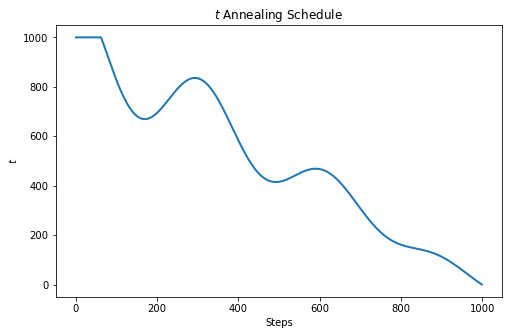

In [9]:
diffusion = GaussianDiffusion(T=1000, schedule='linear')

steps = 1000
t_vals = []
for i in range(steps):  
    # Select t
    t = ((steps-i) + (steps-i)/5*math.cos(i/50))/steps*diffusion.T # Linearly decreasing + cosine

    t = np.clip(t, 1, diffusion.T)
    t = np.array([t for _ in range(batch_size)])#.astype(int)
    
    t_vals.append(t[0])
    
plt.figure(figsize=(8,5))
plt.plot(range(steps), t_vals, linewidth=2)
plt.title('$t$ Annealing Schedule')
plt.xlabel('Steps')
plt.ylabel('$t$')
plt.show()

In [180]:
# Sample random batch
for batch in dataloader:
    naip = batch['naip']
    labels = batch['labels']
    clusters = batch['clusters']
    prior = batch['prior']
    
    labels_one_hot = F.one_hot(labels.long(), n_labels).transpose(-1,1).squeeze(-1).float()
    #clusters = F.one_hot(clusters.long(), n_clusters).transpose(-1,1).squeeze(-1).float()
    break

def normal_cdf(x, mu, sigma):
    return 0.5 * (1 + torch.erf((x-mu)/(sigma*math.sqrt(2))))

def encode_prob(seg, sigma):
    # Encode learned map into probabilities
    x = normal_cdf(1.5, seg, sigma) - normal_cdf(0.5, seg, sigma)
    # Normalize
    x = F.normalize(x + 1e-9, p=1, dim=1)
    return x

In [181]:
import overlap_cluster

# Re-run overlap clustering if needed
oc_clusters = []
naip_down = F.avg_pool2d(naip, 3, 4, 1)
for i in range(naip.shape[0]):
    n_clusters = 5
    clusters, _, _, _ = overlap_cluster.run_clustering(naip_down[i], n_classes=n_clusters, radius=7, n_iter=30, stride=1, 
                                                         warmup_steps=5, warmup_radius=15, device=device)
    clusters = torch.from_numpy(clusters).view(-1,n_clusters,naip_down.shape[2],naip_down.shape[3])
    oc_clusters.append(clusters)

oc_clusters = torch.cat(oc_clusters, dim=0)

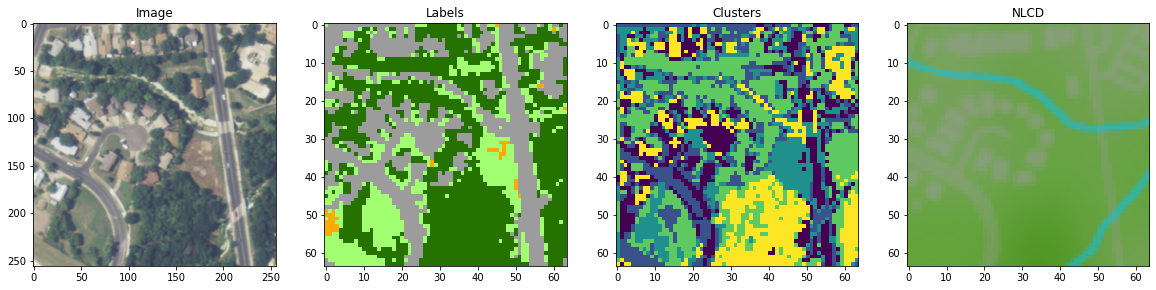

In [182]:
# Visualize
idx = np.random.randint(0, naip.shape[0])

oc_clusters_down = F.interpolate(oc_clusters, scale_factor=1, mode='nearest')

fig, ax = plt.subplots(1, 4, figsize=(20,5))
ax[0].imshow(naip[idx].cpu().numpy().transpose([1,2,0])[:,:,:3])
ax[0].set_title('Image')
ax[1].imshow(labels_to_color(labels[idx].cpu().numpy(), True, enviroatlas_simplified_labels, enviroatlas_simplified_label_colors))
ax[1].set_title('Labels')
ax[2].imshow(torch.argmax(oc_clusters_down[idx], dim=0).numpy())
ax[2].set_title('Clusters')
ax[3].imshow(labels_to_color(prior[idx].cpu().numpy(), False, enviroatlas_simplified_labels, enviroatlas_simplified_label_colors))
ax[3].set_title('NLCD')
plt.show()

  0%|          | 0/500 [00:00<?, ?it/s, Loss=0.0167]

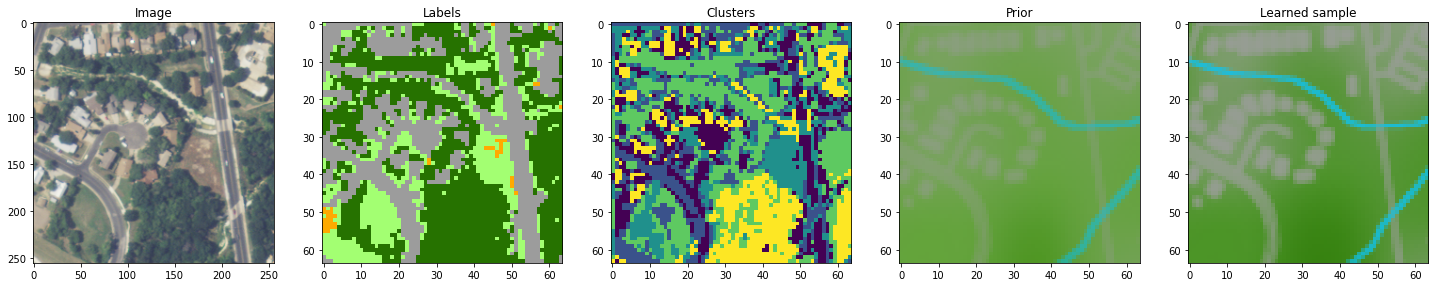

 20%|█▉        | 99/500 [00:05<00:21, 18.93it/s, Loss=0.00933]

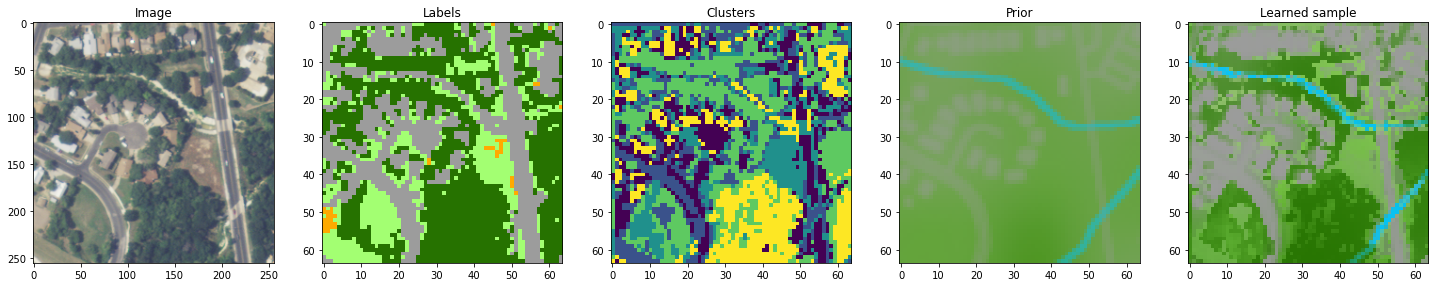

 40%|███▉      | 199/500 [00:11<00:16, 18.71it/s, Loss=-.0108]

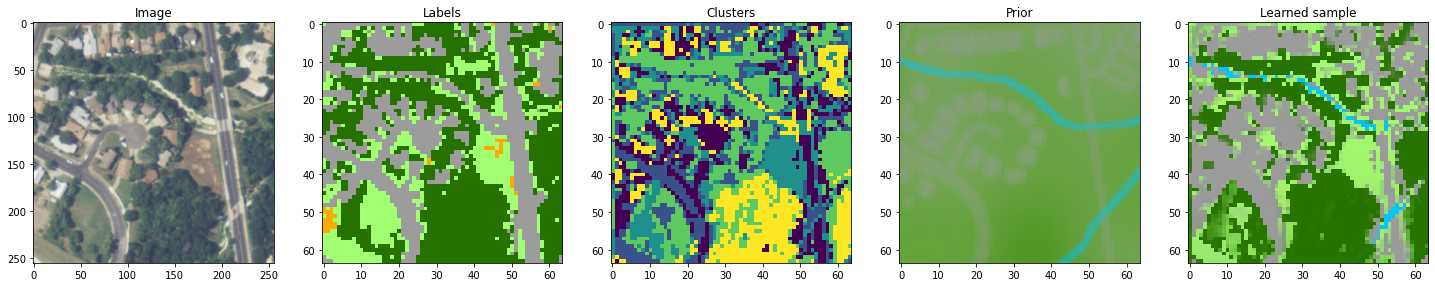

 60%|█████▉    | 299/500 [00:18<00:10, 18.58it/s, Loss=-.0364]

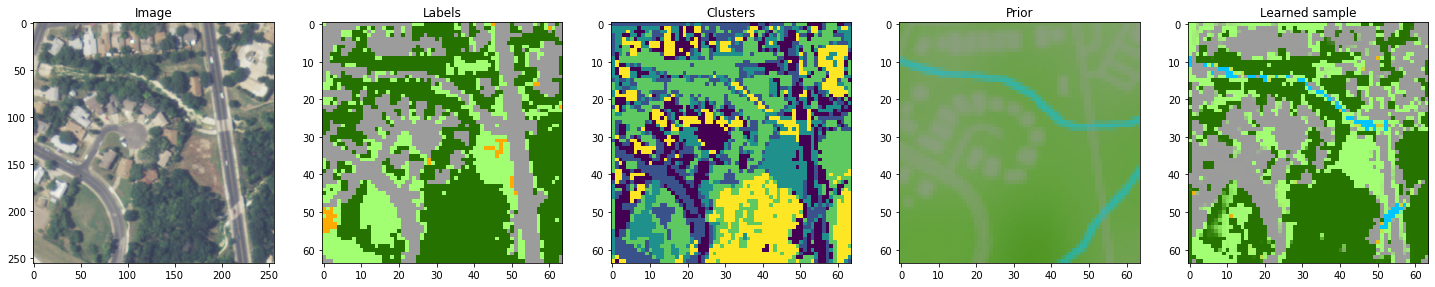

 80%|███████▉  | 399/500 [00:23<00:05, 18.73it/s, Loss=0.21]  

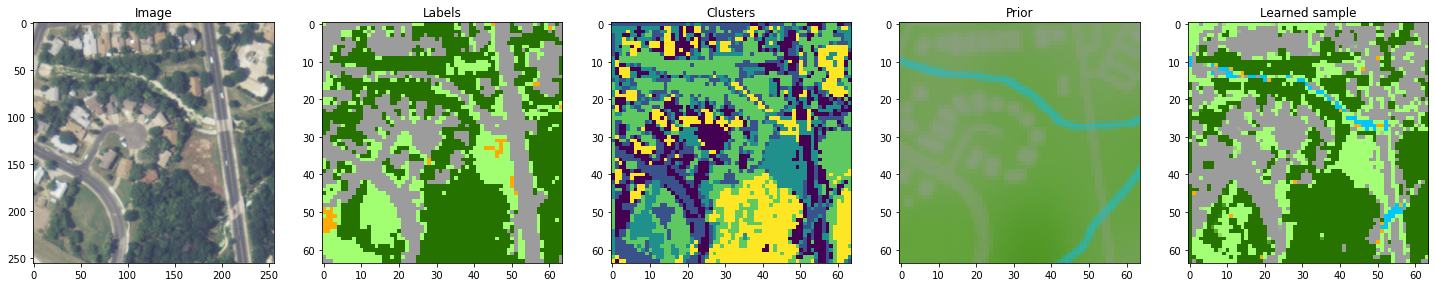

100%|█████████▉| 499/500 [00:29<00:00, 18.58it/s, Loss=0.514]

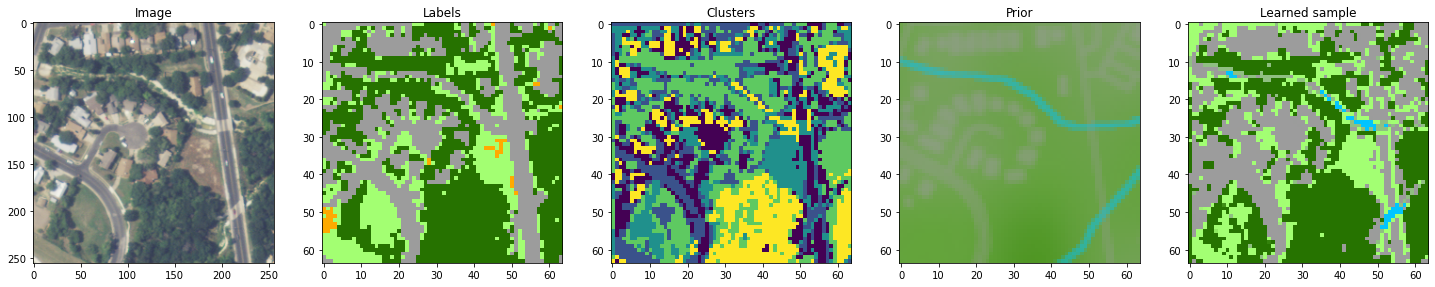

100%|██████████| 500/500 [00:30<00:00, 16.43it/s, Loss=0.514]


In [183]:
class Model(nn.Module):
    def __init__(self, size=(64,64)):
        super(Model, self).__init__()
        self.size = size

        # Infer the one-hot segmentation map
        # Initialize with the prior + added uncertainty
        self.seg_map = nn.Parameter(F.normalize(prior.clone() + 1e-2, p=1, dim=1))
        self.seg_map.requires_grad = True
        
    def encode(self):
        return self.seg_map
    
    def __normal_cdf(self, x, mu, sigma):
            return 0.5 * (1 + torch.erf((x-mu)/(sigma*math.sqrt(2))))
        
    def encode_prob(self, sigma):
        # Encode learned map into probabilities
        x = self.__normal_cdf(1.5, self.seg_map, sigma) - self.__normal_cdf(0.5, self.seg_map, sigma)
        # Normalize
        x = F.normalize(x + 1e-9, p=1, dim=1)
        return x
    
steps = 500
    
model = Model().to(device)
model.train()
opt = torch.optim.Adam(model.parameters(), lr=0.001)#, betas=(0, 0.999))
scheduler = torch.optim.lr_scheduler.LinearLR(opt, start_factor=1, end_factor=0.0001, total_iters=steps)

diffusion = GaussianDiffusion(T=1000, schedule='linear')
diffusion_net.train()

batch_size = prior.shape[0]

bar = tqdm.tqdm(range(steps))
losses = []
update_every = 50
vis_every = 100
for i, _ in enumerate(bar):     
    # Select t
    t = ((steps-i)/3 + (steps-i)/10*math.cos(i/30))/steps*diffusion.T # Linearly decreasing + cosine
    t = np.array([t + 0*np.random.randint(-10, 11, (1,)) for _ in range(batch_size)]).astype(int)
    t = np.clip(t, 1, diffusion.T)
                  
    # Denoise
    seg_map = model.encode()
    xt, epsilon = diffusion.sample(seg_map, t)
    
    t = torch.from_numpy(t).float().view(-1)
    epsilon_pred = diffusion_net(xt.float(), t.to(device))
    
    # Compute MI 
    # Reduce MI window gradually
    k = steps-i
    if k > 4*steps//5:
        win_size = 31
    elif k > 3*steps//5:
        win_size = 25
    elif k > 2*steps//5:
        win_size = 17
    elif k > 1*steps//5:
        win_size = 11
    else:
        win_size = 7
    win_size = 31
    mi_loss = MILoss(win_size)
    
    # Reduce sigma gradually
    sigma = np.clip(0.2*(steps-i)/steps, 0.02, 1)
    cluster_loss = mi_loss(model.encode_prob(sigma), oc_clusters.float().to(device), n_clusters).mean()
    
    nlcd_loss = NLCDLoss(31)
    loss_nlcd = nlcd_loss(model.encode_prob(sigma), prior.float().to(device)).mean()
        
    # Compute loss and backprop
    loss = F.mse_loss(epsilon, epsilon_pred) - np.clip((steps-i)/steps, 0, 1)*cluster_loss + np.clip((steps-i)/steps, 0, 1)*loss_nlcd
    
    opt.zero_grad()
    loss.backward() 
    opt.step()
    scheduler.step()
    
    losses.append(loss.item())
    if i % update_every == 0:
        bar.set_postfix({'Loss': np.mean(losses)})
        losses = []

    # Visualize sample
    if (i+1) % vis_every == 0 or i == 0:
        fig, ax = plt.subplots(1, 5, figsize=(25,5))
        ax[0].imshow(naip[0].cpu().numpy().transpose([1,2,0])[:,:,:3])
        ax[0].set_title('Image')
        ax[1].imshow(labels_to_color(labels[0].numpy(), True, enviroatlas_simplified_labels, enviroatlas_simplified_label_colors))
        ax[1].set_title('Labels')
        ax[2].imshow(torch.argmax(oc_clusters[0], dim=0).numpy())
        ax[2].set_title('Clusters')
        ax[3].imshow(labels_to_color(prior[0].cpu().numpy(), False, enviroatlas_simplified_labels, enviroatlas_simplified_label_colors))
        ax[3].set_title('Prior')
        ax[4].imshow(labels_to_color(model.encode_prob(sigma)[0].detach().cpu().numpy(), False, enviroatlas_simplified_labels, enviroatlas_simplified_label_colors))
        ax[4].set_title('Learned sample')
        plt.show()
        
    plt.imsave(f'vis/sample/{i:04d}.png', labels_to_color(model.encode_prob(sigma)[0].detach().cpu().numpy(), False, enviroatlas_simplified_labels, enviroatlas_simplified_label_colors).astype(np.uint8))

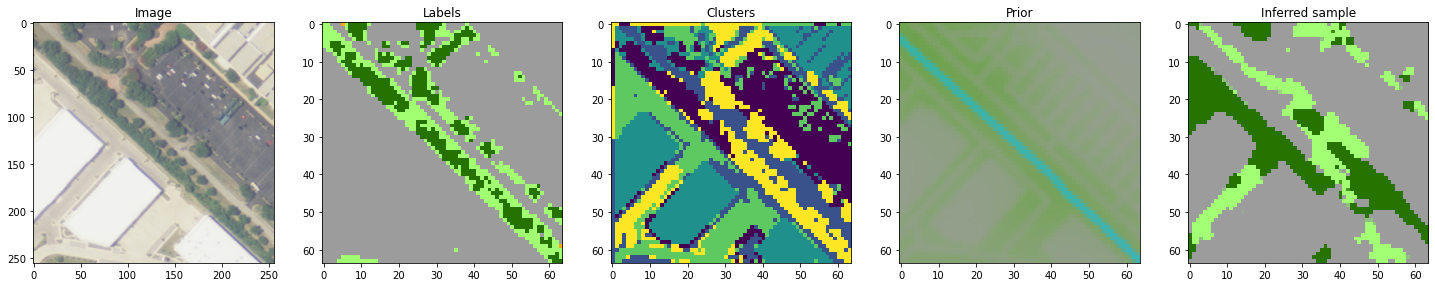

In [120]:
# Visualize sample
idx = np.random.randint(0, naip.shape[0])

fig, ax = plt.subplots(1, 5, figsize=(25,5))
ax[0].imshow(naip[idx].cpu().numpy().transpose([1,2,0])[:,:,:3])
ax[0].set_title('Image')
ax[1].imshow(labels_to_color(labels[idx].numpy(), True, enviroatlas_simplified_labels, enviroatlas_simplified_label_colors))
ax[1].set_title('Labels')
ax[2].imshow(torch.argmax(oc_clusters[idx], dim=0).numpy())
ax[2].set_title('Clusters')
ax[3].imshow(labels_to_color(prior[idx].cpu().numpy(), False, enviroatlas_simplified_labels, enviroatlas_simplified_label_colors))
ax[3].set_title('Prior')
ax[4].imshow(labels_to_color(model.encode_prob(sigma)[idx].detach().cpu().numpy(), False, enviroatlas_simplified_labels, enviroatlas_simplified_label_colors))
ax[4].set_title('Inferred sample')
plt.show()


samples = model.encode_prob(sigma).detach()
for i in range(samples.shape[0]):
    plt.imsave(f'vis/paper/img_{i}.png', naip[i].cpu().numpy().transpose([1,2,0])[:,:,:3])
    plt.imsave(f'vis/paper/labels_{i}.png', labels_to_color(labels[i].numpy(), True, enviroatlas_simplified_labels, enviroatlas_simplified_label_colors).astype(np.uint8))
    plt.imsave(f'vis/paper/clusters_{i}.png', torch.argmax(oc_clusters[i], dim=0).numpy())
    plt.imsave(f'vis/paper/prior_{i}.png', labels_to_color(prior[i].cpu().numpy(), False, enviroatlas_simplified_labels, enviroatlas_simplified_label_colors).astype(np.uint8))

    plt.imsave(f'vis/paper/inferred_seg_{i}.png',
        np.clip(labels_to_color(samples[i].cpu().numpy(), False, enviroatlas_simplified_labels, enviroatlas_simplified_label_colors), 0, 255).astype(np.uint8))

In [78]:
# Run a few steps of diffusion to clean up the inferred samples
diffusion = GaussianDiffusion(T=1000, schedule='linear')

start_t = 200
steps = start_t
x = model.encode_prob(sigma)
x = diffusion.sample(x, np.array([start_t]*x.shape[0]))[0].float()

with torch.no_grad():
    diffusion_net.eval()
    z = diffusion.inverse(diffusion_net, shape=(n_labels,64,64), start_t=start_t, steps=steps, x=x, device=device)
    diffusion_net.train()

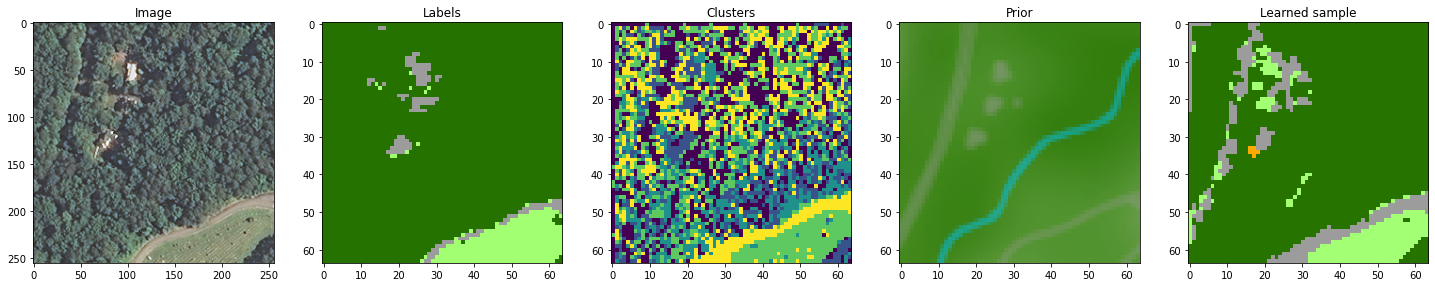

In [87]:
idx = np.random.randint(0, naip.shape[0])

fig, ax = plt.subplots(1, 5, figsize=(25,5))
ax[0].imshow(naip[idx].cpu().numpy().transpose([1,2,0])[:,:,:3])
ax[0].set_title('Image')
ax[1].imshow(labels_to_color(labels[idx].numpy(), True, enviroatlas_simplified_labels, enviroatlas_simplified_label_colors))
ax[1].set_title('Labels')
ax[2].imshow(torch.argmax(oc_clusters[idx], dim=0).numpy())
ax[2].set_title('Clusters')
ax[3].imshow(labels_to_color(prior[idx].cpu().numpy(), False, enviroatlas_simplified_labels, enviroatlas_simplified_label_colors))
ax[3].set_title('Prior')
ax[4].imshow(labels_to_color(encode_prob(z, sigma)[idx].detach().cpu().numpy(), False, enviroatlas_simplified_labels, enviroatlas_simplified_label_colors))
ax[4].set_title('Learned sample')
plt.show()

## Create Dataset of Inferred Patches

In [71]:
class Model(nn.Module):
    def __init__(self, init=None, batch_size=1, size=(64,64)):
        super(Model, self).__init__()
        self.batch_size = batch_size
        self.size = size

        if init is None:
            self.seg_map = nn.Parameter(torch.randn((batch_size,len(enviroatlas_simplified_labels),self.size[0],self.size[1])))
        else:
            self.seg_map = nn.Parameter(init.clone())
        self.seg_map.requires_grad = True
        
    def encode(self):
        return self.seg_map
    
    def __normal_cdf(self, x, mu, sigma):
            return 0.5 * (1 + torch.erf((x-mu)/(sigma*math.sqrt(2))))
        
    def encode_prob(self, sigma):
        # Encode learned map into probabilities
        x = self.__normal_cdf(1.5, self.seg_map, sigma) - self.__normal_cdf(0.5, self.seg_map, sigma)
        # Normalize
        x = F.normalize(x + 1e-9, p=1, dim=1)
        return x
    
def normal_cdf(x, mu, sigma):
    return 0.5 * (1 + torch.erf((x-mu)/(sigma*math.sqrt(2))))

def encode_prob(seg, sigma):
    # Encode learned map into probabilities
    x = normal_cdf(1.5, seg, sigma) - normal_cdf(0.5, seg, sigma)
    # Normalize
    x = F.normalize(x + 1e-9, p=1, dim=1)
    return x

In [ ]:
# Generation parameters
n_samples = 20
save_dir = 'inferred_patches/'
save_idx = 0

diffusion = GaussianDiffusion(T=1000, schedule='linear')
diffusion_net.train()

for sample_idx in range(n_samples):
    print(f'[{sample_idx+1}/{n_samples}]')

    # Sample NAIP patch
    for batch in dataloader:
        naip = batch['naip']
        labels = batch['labels']
        #clusters = batch['clusters']
        prior = batch['prior']
        
        labels_one_hot = F.one_hot(labels.long(), n_labels).transpose(-1,1).squeeze(-1).float()
        #clusters = F.one_hot(clusters.long(), n_clusters).transpose(-1,1).squeeze(-1).float()
        
    # Run overlap clustering
    oc_clusters = []
    naip_down = F.avg_pool2d(naip, 3, 4, 1)
    for i in range(naip.shape[0]):
        n_clusters = 5
        clusters, _, _, _ = overlap_cluster.run_clustering(naip_down[i], n_classes=n_clusters, radius=7, n_iter=30, stride=1, 
                                                             warmup_steps=5, warmup_radius=15, device=device)
        clusters = torch.from_numpy(clusters).view(-1,n_clusters,naip_down.shape[2],naip_down.shape[3])
        oc_clusters.append(clusters)

    oc_clusters = torch.cat(oc_clusters, dim=0)
    
    # Initialize model with prior
    model = Model(init=prior, batch_size=prior.shape[0]).to(device)
    model.train()
    opt = torch.optim.Adam(model.parameters(), lr=0.005, betas=(0, 0.999))
    scheduler = torch.optim.lr_scheduler.LinearLR(opt, start_factor=1, end_factor=0.001, total_iters=steps)

    # Infer sample
    steps = 200
    bar = tqdm.tqdm(range(steps))
    losses = []
    update_every = 50
    vis_every = 100
    for i, _ in enumerate(bar):     
        # Select t
        #t = np.random.randint(1, diffusion.T+1, batch_size).astype(int) # Uniform
        #t = 800*(math.cos(i/110)+1)*0.5*math.exp(-5e-4*i) # Cosine
        t = ((steps-i)//3 + (steps-i)//10*math.cos(i/10))/steps*diffusion.T # Linearly decreasing + cosine

        t = np.array([t + 0*np.random.randint(-10, 11, (1,)) for _ in range(batch_size)]).astype(int)
        t = np.clip(t, 1, diffusion.T)

        # Denoise
        seg_map = model.encode()
        xt, epsilon = diffusion.sample(seg_map, t)

        t = torch.from_numpy(t).float().view(-1)
        epsilon_pred = diffusion_net(xt.float(), t.to(device))

        # Compute MI 
        # Reduce MI window gradually
        k = steps-i
        if k > 4*steps//5:
            win_size = 31
        elif k > 3*steps//5:
            win_size = 25
        elif k > 2*steps//5:
            win_size = 17
        elif k > 1*steps//5:
            win_size = 11
        else:
            win_size = 7
        win_size = 31
        mi_loss = MILoss(win_size)

        # Reduce sigma gradually
        sigma = np.clip(0.2*(steps-i)/steps, 0.02, 1)
        cluster_loss = mi_loss(model.encode_prob(sigma), oc_clusters.float().to(device), n_clusters).mean()

        nlcd_loss = NLCDLoss(31)
        loss_nlcd = nlcd_loss(model.encode_prob(sigma), prior.float().to(device)).mean()

        # Compute loss and backprop
        loss = F.mse_loss(epsilon, epsilon_pred) - (steps-i)/steps*cluster_loss + (steps-i)/steps*loss_nlcd

        opt.zero_grad()
        loss.backward() 
        opt.step()
        scheduler.step()

    diffusion = GaussianDiffusion(T=1000, schedule='linear')

    start_t = 100
    steps = start_t
    x = model.encode_prob(sigma)

    with torch.no_grad():
        diffusion_net.eval()
        z = diffusion.inverse(diffusion_net, shape=(n_labels,64,64), start_t=start_t, steps=steps, x=x, device=device)
        diffusion_net.train()
    
    # Save image/inferred segmentation
    for i in range(naip.shape[0]):
        np.save(f'{save_dir}/az/{save_idx}_img.npy', naip[i,...].cpu().numpy())
        np.save(f'{save_dir}/az/{save_idx}_seg.npy', model.encode_prob(2*sigma)[i,...].detach().cpu().numpy()) # Added 2*sigma
        np.save(f'{save_dir}/az/{save_idx}_seg_finetuned.npy', encode_prob(z, sigma)[i,...].detach().cpu().numpy())
        
        save_idx += 1
        

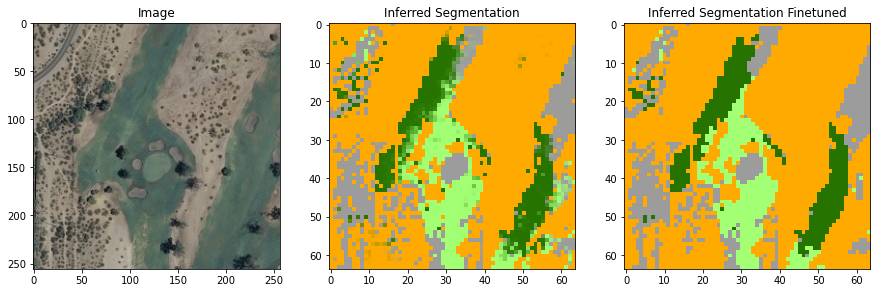

In [76]:
idx = np.random.randint(0, 640)

img_patch = np.load(f'inferred_patches/az/{idx}_img.npy')
seg_patch = np.load(f'inferred_patches/az/{idx}_seg.npy')
seg_patch_finetuned = np.load(f'inferred_patches/az/{idx}_seg_finetuned.npy')

# Visualize
fig, ax = plt.subplots(1, 3, figsize=(15,5))
ax[0].imshow(img_patch.transpose([1,2,0])[:,:,:3])
ax[0].set_title('Image')
ax[1].imshow(labels_to_color(seg_patch, False, enviroatlas_simplified_labels, enviroatlas_simplified_label_colors))
ax[1].set_title('Inferred Segmentation')
ax[2].imshow(labels_to_color(seg_patch_finetuned, False, enviroatlas_simplified_labels, enviroatlas_simplified_label_colors))
ax[2].set_title('Inferred Segmentation Finetuned')
plt.show()

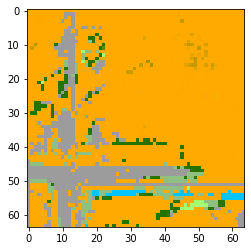

In [201]:
plt.figure()

plt.imshow(labels_to_color(model.encode_prob(sigma)[i,...].detach().cpu().numpy(), False, enviroatlas_simplified_labels, enviroatlas_simplified_label_colors))
plt.show()